In [1]:
# import os
import time
from hydra_zen import instantiate, make_config, builds
# import sys

In [2]:
import jax.numpy as np
from jax import random, vmap, grad
from scipy.stats import special_ortho_group
from numpy.random import seed as set_numpy_seed

In [3]:
# from grassgp.utils import get_save_path
# from grassgp.utils import safe_save_jax_array_dict as safe_save
# from grassgp.utils import load_and_convert_to_samples_dict as load_data
from grassgp.grassmann import valid_grass_point, grass_log, compute_barycenter
from grassgp.kernels import rbf
from grassgp.models_optimised import GrassGP
from grassgp.means import zero_mean
# from grassgp.plot_utils import flatten_samples, plot_grass_dists

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
import numpyro
from numpyro.infer import SVI, Trace_ELBO, autoguide, init_to_value
import numpyro.distributions as dist

In [5]:
from grassgp.inference import run_inference

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

In [7]:
def run_svi_for_map(rng_key, model, maxiter, step_size, *args):
    start = time.time()
    guide = autoguide.AutoDelta(model)
    optimzer = numpyro.optim.Adam(step_size)
    svi = SVI(model, guide, optimzer, Trace_ELBO())
    svi_results = svi.run(rng_key, maxiter, *args)
    print('\nSVI elapsed time:', time.time() - start)
    return svi_results

In [8]:
# generate training spatial points
xlims = (-10, 10)
ylims = (-10, -4)
n_train_tmp = 114
# n_train_tmp = 50
ys = [y for y in range(ylims[0], ylims[1], 1)]
s_train = []
for y in ys:
    for x in np.linspace(xlims[0], xlims[1], n_train_tmp // len(ys)):
        s = [x, y]
        s_train.append(s)

s_train = np.array(s_train)
n_train = s_train.shape[0]

In [9]:
# generate test spatial points
n_test = 86
# n_test = 30
key_s_test = random.PRNGKey(235326)
key_x_test, key_y_test = random.split(key_s_test, 2)
x_test = random.uniform(key_x_test, shape=(n_test, 1), minval=xlims[0], maxval=xlims[1])
y_test = random.uniform(key_y_test, shape=(n_test, 1), minval=ylims[0], maxval=ylims[1])
s_test = np.hstack((x_test, y_test))

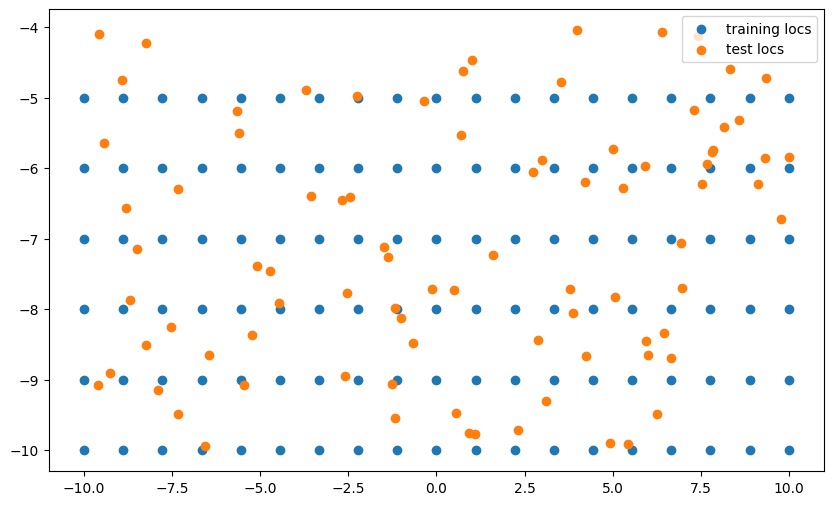

In [10]:
plt.scatter(s_train[:,0],s_train[:, 1], label='training locs')
plt.scatter(s_test[:,0],s_test[:, 1], label='test locs')
plt.legend()
plt.show()

In [11]:
# generate random rotation matrix in R^d
# d = 10
d = 5
set_numpy_seed(26436)
R = np.array(special_ortho_group.rvs(d))

In [12]:
# get the u vectors associated with each s in train and test set
# include in R^10
s_train_d = vmap(lambda s: np.concatenate((s, np.zeros(d - len(s)))))(s_train)
s_test_d = vmap(lambda s: np.concatenate((s, np.zeros(d - len(s)))))(s_test)
# rotate using R
u_train = vmap(lambda s_d: R @ s_d)(s_train_d)
u_test = vmap(lambda s_d: R @ s_d)(s_test_d)

In [13]:
# compute the c_hat matrices
def f(u):
    return np.linalg.norm(u)**2


grad_f = grad(f)

grads_train = vmap(grad_f)(u_train)
grads_test = vmap(grad_f)(u_test)

C_hat_train = vmap(lambda gradient: np.outer(gradient, gradient))(grads_train)
C_hat_test = vmap(lambda gradient: np.outer(gradient, gradient))(grads_test)

In [14]:
# def get_AS(C_hat, tol_check=1e-3):
#     eigs, eig_vecs = np.linalg.eig(C_hat)
#     assert sum(np.abs(eigs) >= tol_check) == 1
    
#     # get index of non-zero eigenvalue
#     ind = np.real(eigs).argsort()[-1]  # sort real part and take largest one
#     # get corresponding eigenvector; this is the active subspace direction
#     w = np.real(eig_vecs[:, ind])
#     assert np.linalg.norm(C_hat @ w - np.real(eigs[ind]) * w) / np.linalg.norm(np.real(eigs[ind]) * w) < tol_check
#     return w

In [15]:
def get_AS(C_hat, tol_check=1e-3):
    eigs, eig_vecs = np.linalg.eigh(C_hat)
    assert sum(np.abs(eigs) >= tol_check) == 1
    
    # get index of non-zero eigenvalue
    ind = eigs.argsort()[-1]  # sort real part and take largest one
    # get corresponding eigenvector; this is the active subspace direction
    w = np.real(eig_vecs[:, ind])
    assert np.linalg.norm(C_hat @ w - np.real(eigs[ind]) * w) / np.linalg.norm(np.real(eigs[ind]) * w) < tol_check
    return w

In [16]:
Ws_train = []
for i in range(n_train):
    w = get_AS(C_hat_train[i])
    Ws_train.append(w)
    
Ws_test = []
for i in range(n_test):
    w = get_AS(C_hat_test[i])
    Ws_test.append(w)
    
Ws_train = np.array(Ws_train)[:,:,None]
Ws_test = np.array(Ws_test)[:,:,None]

# check data are valid Grass points
assert vmap(valid_grass_point)(Ws_train).all()
assert vmap(valid_grass_point)(Ws_test).all()

In [17]:
# compute barycenter of train data
anchor_point = np.array(compute_barycenter(Ws_train))
assert valid_grass_point(anchor_point)

In [18]:
# compute log of training data and full data
log_Ws_train = vmap(lambda W: grass_log(anchor_point, W))(Ws_train)
log_Ws_test = vmap(lambda W: grass_log(anchor_point, W))(Ws_test)

In [19]:
# Omega = np.cov(vmap(vec)(Ws_train), rowvar=False)
# assert Omega.shape == (d,d)
# Omega += 1e-8 * np.eye(d)
# print(f"{np.linalg.det(Omega)=}")
# mat_heatmap(Omega)
# K_tmp = rbf(s_train, s_train, {'var': 1.0, 'length': 1.0, 'noise': 0.0})
# Cov = np.kron(K_tmp, Omega)
# sns.heatmap(Cov,cbar=True,
#               annot=False,
#               xticklabels=False,
#               yticklabels=False,
#               cmap=cm.viridis)
# plt.show()
# sparse_tol = 1e-4
# (np.abs(Cov) < sparse_tol).sum() / (Cov.shape[0] * Cov.shape[1])

In [24]:
model_config = {
    'anchor_point': anchor_point.tolist(),
    'd_in': 2,
    'Omega_diag_chol' : None,
    # 'Omega_diag_chol' : Omega.tolist(),
    'k_include_noise': True,
    'var' : 1.0,
    'length' : None, 
    'noise' : None,
    'require_noise' : False,
    'jitter' : 1e-06,
    'cov_jitter' : 1e-4,
    'L_jitter' : 1e-8,
    'reorthonormalize' : False,
    # 'b' : 0.5, # mine
    'b' : 0.001, # savvas
    # 'ell': 0.0075
    # 'ell': 0.01, # mine
    'use_kron_chol': False
}
def model(s, log_Ws, grass_config = model_config):
    U = np.array(grass_config['anchor_point'])
    d, n = U.shape
    N = s.shape[0]
    d_n = d * n
    # N_params = N * d_n
    if log_Ws is not None:
        assert log_Ws.shape == (N, d, n), f"log_Ws.shape=({log_Ws.shape}) instead of {(N, d, n)} as expected"

    # get/sample Omega
    if grass_config['Omega_diag_chol'] is None:
        # full example
        # sigmas = numpyro.sample('sigmas', dist.LogNormal(0.0, 1.0).expand([d_n]))
        # L_factor = numpyro.sample('L_factor', dist.LKJ(d_n, 1.0))
        # L = numpyro.deterministic('L', L_factor + grass_config['L_jitter'] * np.eye(d_n))
        # Omega = numpyro.deterministic('Omega', np.outer(sigmas, sigmas) * L)
        # simpler diagonal structure
        # sigmas = numpyro.sample('sigmas', dist.LogNormal(0.0, 1.0).expand([d_n]))
        # Omega_diag = numpyro.deterministic('Omega_diag', sigmas**2)
        Omega_diag_chol = numpyro.sample('Omega_diag_chol', dist.LogNormal(0.0, 1.0).expand([d_n]))
    else:
        Omega_diag_chol = np.array(grass_config['Omega_diag_chol'])
        
    # get/sample kernel params
    if grass_config['var'] is None:
        # sample var
        var = numpyro.sample("kernel_var", dist.LogNormal(0.0, grass_config['b']))
    else:
        var = grass_config['var']

    if grass_config['length'] is None:
        # sample length
        # ! my parametrisation
        # length = numpyro.sample("kernel_length", dist.LogNormal(0.0, grass_config['b']))
        # ! savvas parametrisation
        length = numpyro.sample("kernel_length", dist.LogNormal(-0.7, grass_config['b']))
    else:
        length = grass_config['length']

    if grass_config['require_noise']:
        if grass_config['noise'] is None:
            # sample noise
            noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, grass_config['b']))
        else:
            noise = grass_config['noise']
    else:
        noise = 0.0
    

    # kernel_params = {'var': var, 'length': length, 'noise': noise} # mine
    kernel_params = {'var': var, 'length': np.sqrt(1/length), 'noise': noise} # savvas
    # create kernel function
    k = lambda t, s: rbf(t, s, kernel_params, jitter=grass_config['jitter'], include_noise=grass_config['k_include_noise'])
    # create mean function
    mu = lambda s: zero_mean(s, d, n)

    # initialize GrassGp
    grass_gp = GrassGP(d_in=grass_config['d_in'], d_out=(d,n), mu=mu, k=k, Omega_diag_chol=Omega_diag_chol, U=U, cov_jitter=grass_config['cov_jitter'])

    # sample Deltas
    Deltas = grass_gp.tangent_model(s, use_kron_chol=grass_config['use_kron_chol'])

    # # # # ! check what power this should be
    # likelihood
    # ell = grass_config['ell'] # mine
    ell = numpyro.sample("ell", dist.LogNormal(-6, 0.0015))
    with numpyro.plate("N", N):
        numpyro.sample("log_W", dist.continuous.MatrixNormal(loc=Deltas, scale_tril_row=ell * np.eye(d), scale_tril_column=np.eye(n)), obs=log_Ws)

TangentSpaceModelConf = builds(model, grass_config=model_config, zen_partial=True)

In [25]:
SVIConfig = make_config(
    seed = 123514354575,
    maxiter = 15000,
    step_size = 0.001
)

TrainConfig = make_config(
    seed = 9870687,
    n_warmup = 2000,
    n_samples = 7000,
    n_chains = 1,
    n_thinning = 2
)

Config = make_config(
    model = TangentSpaceModelConf,
    svi = SVIConfig,
    train = TrainConfig
)

In [26]:
def train(cfg):
    # instantiate grass model
    model = instantiate(cfg.model)

    # # save training-test data
    # head = os.getcwd()
    # training_test_data = {'s_train': s_train, 's_test': s_test, 'Ws_train': Ws_train, 'Ws_test': Ws_test, 'log_Ws_train': log_Ws_train, 'log_Ws_test': log_Ws_test, 'anchor_point': anchor_point}
    # training_test_main_name = "training_test_data"
    # training_test_path = get_save_path(head, training_test_main_name)
    # try:
    #     safe_save(training_test_path, training_test_data)
    # except FileExistsError:
    #     print("File exists so not saving.")
    
    # run SVI to get MAP esimtate to initialise MCMC
    svi_key = random.PRNGKey(cfg.svi.seed)
    maxiter = cfg.svi.maxiter
    step_size = cfg.svi.step_size
    print("Running SVI for MAP estimate to initialise MCMC")
    svi_results = run_svi_for_map(svi_key, model, maxiter, step_size, s_train, log_Ws_train)
    
    # plot svi losses
    plt.plot(svi_results.losses)
    plt.show()
    
    # get initialisation from SVI results
    map_est = svi_results.params
    strip_val = len('_auto_loc')
    init_values = {key[:-strip_val]:value for (key, value) in map_est.items()}
    
    # run HMC
    train_key = random.PRNGKey(cfg.train.seed)
    mcmc_config = {'num_warmup' : cfg.train.n_warmup, 'num_samples' : cfg.train.n_samples, 'num_chains' : cfg.train.n_chains, 'thinning' : cfg.train.n_thinning, 'init_strategy' : init_to_value(values=init_values)}
    print("HMC starting.")
    mcmc = run_inference(train_key, mcmc_config, model, s_train, log_Ws_train)    
    # original_stdout = sys.stdout
    # with open('hmc_log.txt', 'w') as f:
    #     sys.stdout = f
    #     mcmc.print_summary()
    #     sys.stdout = original_stdout
    
    samples = mcmc.get_samples()
    inference_data = samples.copy()
    for param, initial_val in init_values.items():
        inference_data[f"{param}-initial_value"] = initial_val
    
    # inference_main_name = "inference_data"
    # inference_path = get_save_path(head, inference_main_name)
    # try:
    #     safe_save(inference_path, inference_data)
    # except FileExistsError:
    #     print("File exists so not saving.")
    return inference_data

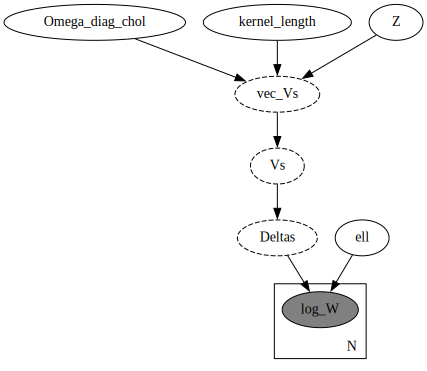

In [27]:
numpyro.render_model(instantiate(Config.model), model_args=(s_train,log_Ws_train))

Running SVI for MAP estimate to initialise MCMC


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:01<00:00, 242.36it/s, init loss: 6782658.1750, avg. loss [14251-15000]: -2373.8345]



SVI elapsed time: 71.10443949699402


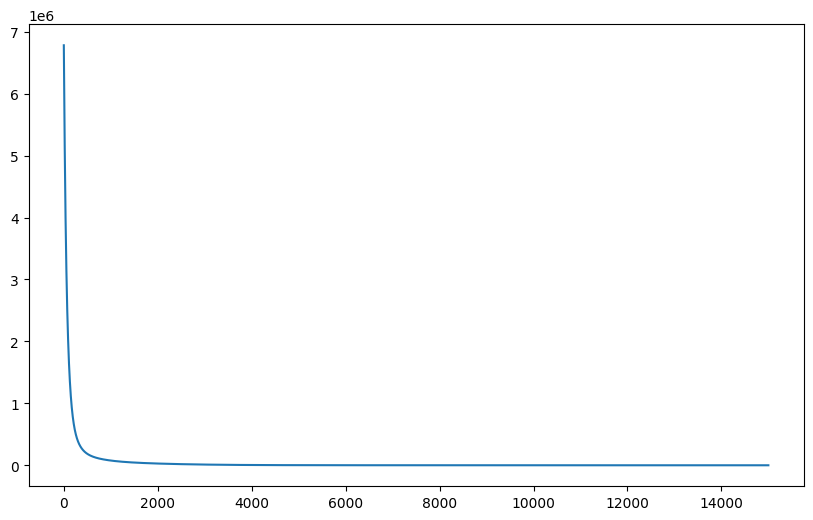

HMC starting.


warmup:   3%|███▋                                                                                                                     | 277/9000 [08:02<4:13:08,  1.74s/it, 4 steps of size 1.92e-03. acc. prob=0.77]


KeyboardInterrupt: 

In [28]:
inference_data = train(Config)